In [176]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from itertools import combinations

In [177]:
# How many particles we simulate
NUM_PARTICLES = 500
# Max particle starting speed in m/s
SPEED = 1

In [178]:
# ID for each particle
ids = np.arange(NUM_PARTICLES)

# Initialise with random starting positions between 0 and 1
# startx = np.random.random(NUM_PARTICLES)
# starty = np.random.random(NUM_PARTICLES)
pos = np.random.random((2, NUM_PARTICLES))

# Initialise random starting velocities, between -SPEED and SPEED
# vx = (np.random.random(NUM_PARTICLES) - 0.5) * SPEED * 2
# vy = (np.random.random(NUM_PARTICLES) - 0.5) * SPEED * 2
vs = (np.random.random((2, NUM_PARTICLES)) - 0.5) * SPEED * 2


# Particles on the right will be coloured red, on the left will be blue
red = pos[0] > 0.5
blue = pos[0] <= 0.5

In [179]:
def show(pos, ax):
    ax.scatter(pos[0][red], pos[1][red], color='r', s=6)
    ax.scatter(pos[0][blue], pos[1][blue], color='b', s=6)
# plt.show()

In [180]:
def step(pos, v, dt=0.001):
    pos = pos + v * dt

    return pos, v


FRAMES = 1000

positions = np.zeros((FRAMES, 2, NUM_PARTICLES))
velocities = np.zeros((FRAMES, 2,NUM_PARTICLES))

for i in range(FRAMES):
    positions[i] = pos.copy()
    velocities[i] = vs.copy()
    pos, vs = step(pos, vs)

ValueError: unknown file extension: .mp4

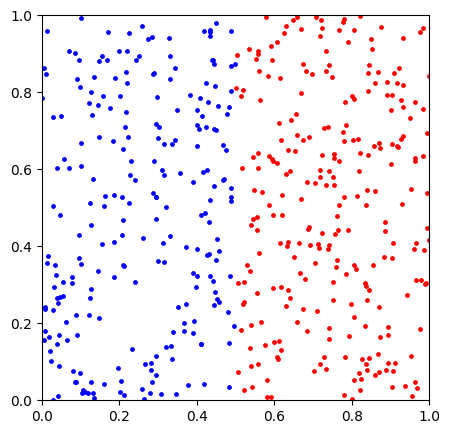

In [181]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
def animate(i):
    ax.clear()
    p = positions[i]
    show(p, ax)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save('test2.gif', writer='pillow', fps=30, dpi=300)

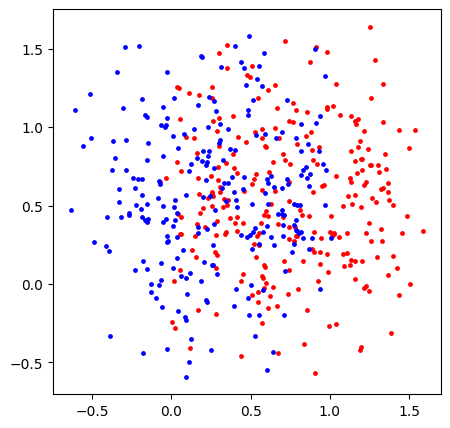

In [ ]:
show()

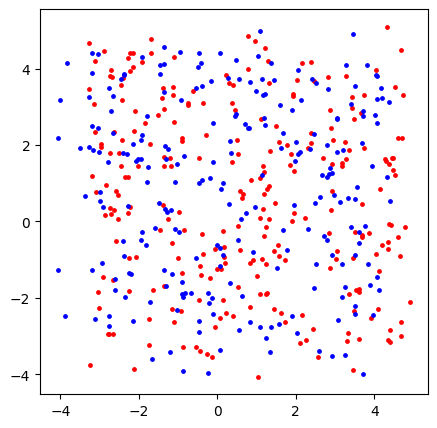

In [ ]:
pos, vs = step(pos, vs, dt=0.001)
show()

In [ ]:
animation.PillowWriter()